# Multi-objective Robust Optimization
A robust optimization method for finding policies under deep uncertainty across scenarios.


### sources:
https://doi.org/10.1007/s10584-014-1210-4
https://emaworkbench.readthedocs.io/en/latest/examples/robust_optimization_lake_model_dps.html
https://github.com/WKSu/Model-based-decision-making/blob/ba6a6f2b9f7f32b56d7e11c9caeaedf5562deea4/MORO.py

### Problem formulation

    0. Total cost, and casualties
    1. Expected damages, costs, and casualties
    2. expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
    3. costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
    4. Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
    5. disaggregate over time and space

Problem formulation 5 was chosen, as it has the most specific indicators

First, packages are imported.

In [23]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress


In [28]:
dike_model, planning_steps = get_model_for_problem_formulation(5)
dike_model.outcomes.keys()

odict_keys(['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [16]:
# set logging style for progression management
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(5)

# robustness metrics
maximize = ScalarOutcome.MAXIMIZE
minimize = ScalarOutcome.MINIMIZE

percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)

# dit kunnen we gebruiken als we stats van alle punten opgeteld willen optimizen
var_list_deaths = ['A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1',
                   'A.1_Expected Number of Deaths 2',
                   'A.2_Expected Number of Deaths 0', 'A.2_Expected Number of Deaths 1',
                   'A.2_Expected Number of Deaths 2',
                   'A.3_Expected Number of Deaths 0', 'A.3_Expected Number of Deaths 1',
                   'A.3_Expected Number of Deaths 2',
                   'A.4_Expected Number of Deaths 0', 'A.4_Expected Number of Deaths 1',
                   'A.4_Expected Number of Deaths 2',
                   'A.5_Expected Number of Deaths 0', 'A.5_Expected Number of Deaths 1',
                   'A.5_Expected Number of Deaths 2'
                   ]

#   de variabelen en manier van optimaliseren, veranderen op basis van wat we moeten optimaliseren
robustness_functions = [
    ScalarOutcome("robust_1", kind=minimize, variable_name="A.5_Expected Number of Deaths", function=percentile90),
    ScalarOutcome("robust_2", kind=minimize, variable_name="A.5_Expected Annual Damage", function=percentile90),
    ScalarOutcome("robust_3", kind=minimize, variable_name="A.5_Dike Investment Costs", function=percentile90),
    ScalarOutcome("robust_4", kind=minimize, variable_name="RfR Total Costs", function=percentile90),
    ScalarOutcome("robust_5", kind=minimize, variable_name="Expected Evacuation Costs", function=percentile90),
]

# general input
n_scenarios = 10
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = 2000 #make this large

# run model
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.robust_optimize(
        robustness_functions,
        scenarios,
        nfe=nfe,
        epsilons=[0.1] * len(robustness_functions),
        population_size=5,
    )

# save to pickle file
with open('robust_optimize_results.pkl', 'wb') as pickle_file:
    pickle.dump(results, pickle_file)

[MainProcess/INFO] pool started with 12 workers
2079it [43:15,  1.25s/it]                                                      
[MainProcess/INFO] optimization completed, found 43 solutions
[MainProcess/INFO] terminating pool


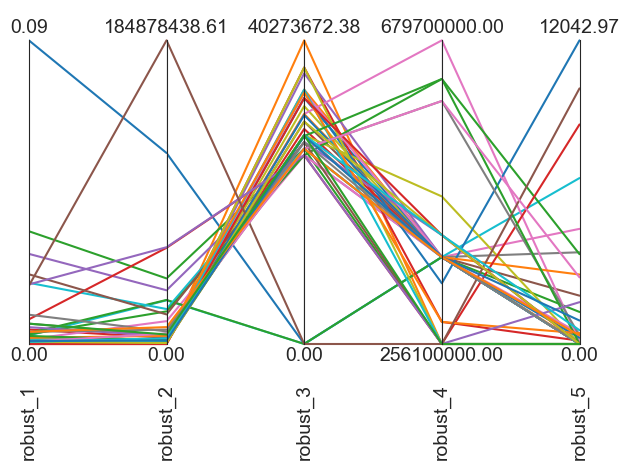

In [18]:
from ema_workbench.analysis import parcoords

# open results from simulation
df = pd.read_pickle('robust_optimize_results.pkl')

data = df.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
# paraxes.invert_axis("robust_3") # this can be used to swap the axis (if higher number = better)
plt.show()

In [19]:
data

,robust_1,robust_2,robust_3,robust_4,robust_5
0,0.085424,1.162808e+08,0.000000e+00,377300000.0,0.000000
1,0.000000,0.000000e+00,4.027367e+07,256100000.0,0.000000
2,0.031708,3.990029e+07,2.589276e+07,256100000.0,0.000000
3,0.004047,3.764773e+06,2.852060e+07,377300000.0,0.000000
4,0.025341,3.267163e+07,2.503721e+07,377300000.0,0.000000
5,0.001773,1.614378e+06,2.949518e+07,377300000.0,0.000000
6,0.001299,1.386082e+07,2.503721e+07,377300000.0,4564.784748
7,0.000642,6.296517e+06,2.589276e+07,377300000.0,3635.453831
8,0.000880,7.932825e+05,3.154537e+07,377300000.0,0.000000
9,0.002390,2.656788e+07,0.000000e+00,377300000.0,6579.793837
